<a href="https://colab.research.google.com/github/chemicoPy/MACD-RSI-STOCHASTIC-strategy/blob/ccxt/MACD_RSI_STOCHASTIC_strategy_(ccxt).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install ccxt
!pip install pandas_ta
!pip install schedule

In [6]:
import ccxt
import pandas as pd
import numpy as np
from numpy import *
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from IPython.display import clear_output
import schedule


In [8]:

API_KEY = ""
API_SECRET = ""

In [9]:
""" Examples_of_coins_are = ["BNBUSDT", "ETHUSDT", "ADAUSDT", "DOTUSDT", "BTCUSDT", "FTMUSDT", "DOGEUSDT", "LINKUSDT", "SUSHIUSDT", "SOLUSDT",
                 "IOSTUSDT", "LTCUSDT", "XRPUSDT", "SXPUSDT", "MATICUSDT", "BCHUSDT"] """

coin = str(input("Enter coin name: ").upper())
interval = str(input("Enter time interval name e.g 5m for 5-minute: ").lower())

""" For example:
coin = 'BTCUSDT'
interval = '1m' """


Enter coin name: btcusdt
Enter time interval name e.g 5m for 5-minute: 1h


" For example:\ncoin = 'BTCUSDT'\ninterval = '1m' "

In [10]:
""" Code line to see all columns of that data grabbed """
exchangepub = ccxt.binanceus()   # You can choose/enter the ID you prefer here e.g binance, coinbase, coinmate, coinmetro e.t.c

exchange_id = 'binanceus'
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'apiKey': API_KEY,
    'secret': API_SECRET,
    'timeout': 3333,
    'enableRateLimit': True,
})

index = coin.find('USDT')
symbol = coin[:index] + '/' + coin[index:]

instrument = exchange.fetchTickers(str(symbol))
print((instrument))

{'BTC/USD': {'symbol': 'BTC/USD', 'timestamp': 1642352724269, 'datetime': '2022-01-16T17:05:24.269Z', 'high': 43828.92, 'low': 42602.14, 'bid': 43318.21, 'bidVolume': 0.162, 'ask': 43330.74, 'askVolume': 0.567, 'vwap': 43238.9806, 'open': 43371.04, 'close': 43325.15, 'last': 43325.15, 'previousClose': 43373.3, 'change': -45.89, 'percentage': -0.106, 'average': 43348.095, 'baseVolume': 479.650263, 'quoteVolume': 20739588.419, 'info': {'symbol': 'BTCUSD', 'priceChange': '-45.8900', 'priceChangePercent': '-0.106', 'weightedAvgPrice': '43238.9806', 'prevClosePrice': '43373.3000', 'lastPrice': '43325.1500', 'lastQty': '0.00045900', 'bidPrice': '43318.2100', 'bidQty': '0.16200000', 'askPrice': '43330.7400', 'askQty': '0.56700000', 'openPrice': '43371.0400', 'highPrice': '43828.9200', 'lowPrice': '42602.1400', 'volume': '479.65026300', 'quoteVolume': '20739588.4190', 'openTime': '1642266324269', 'closeTime': '1642352724269', 'firstId': '28515292', 'lastId': '28537793', 'count': '22502'}}, 'BT

In [11]:
import ccxt

exchangepub = ccxt.binanceus()   # You can choose/enter the ID you prefer here e.g binanceus, coinbase, coinmate, coinmetro e.t.c

exchange_id = 'binanceus'
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'apiKey': API_KEY,
    'secret': API_SECRET,
    'timeout': 3333,
    'enableRateLimit': True,
})

def orderSignal():
  markets = exchange.fetch_ohlcv(coin, timeframe=interval, limit = 1000)
  df = pd.DataFrame(markets, columns=["time", "open", "high", "low", "close", "volume"])
  df.time = pd.to_datetime(df.time, unit='ms')
  df.rename(columns = {'time':'dateTime'}, inplace = True)
  df.set_index('dateTime', inplace=True)
  df['open'] = pd.to_numeric(df['open'], errors='coerce')
  df['high'] = pd.to_numeric(df['high'], errors='coerce')
  df['low'] = pd.to_numeric(df['low'], errors='coerce')
  df['close'] = pd.to_numeric(df['close'], errors='coerce')
  df['volume'] = pd.to_numeric(df['volume'], errors='coerce')

  return df


df = orderSignal()
print(df.tail())


print("")
print("Size of data:", len(df))


                         open      high       low     close    volume
dateTime                                                             
2022-01-16 13:00:00  43003.75  43186.39  42606.27  43145.83  9.801632
2022-01-16 14:00:00  43167.40  43416.07  43046.40  43297.33  7.155894
2022-01-16 15:00:00  43315.11  43350.64  43155.81  43221.98  6.256289
2022-01-16 16:00:00  43236.60  43478.57  43178.57  43380.28  4.421617
2022-01-16 17:00:00  43384.69  43409.24  43288.70  43316.53  0.072478

Size of data: 1000


# MACD - Moving Average Convergence Divergence

In [12]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df
    
macd = get_macd(df['close'], 26, 12, 9)
df = pd.concat([df, macd], join = 'inner', axis = 1)
df.tail()

,open,high,low,close,volume,macd,signal,hist
dateTime,,,,,,,,
2022-01-16 13:00:00,43003.75,43186.39,42606.27,43145.83,9.801632,-12.667532,-2.398589,-10.268944
2022-01-16 14:00:00,43167.40,43416.07,43046.40,43297.33,7.155894,5.857145,-0.747442,6.604587
2022-01-16 15:00:00,43315.11,43350.64,43155.81,43221.98,6.256289,14.293207,2.260688,12.032519
2022-01-16 16:00:00,43236.60,43478.57,43178.57,43380.28,4.421617,33.367692,8.482089,24.885603
2022-01-16 17:00:00,43384.69,43409.24,43288.70,43316.53,0.072478,42.846361,15.354943,27.491417


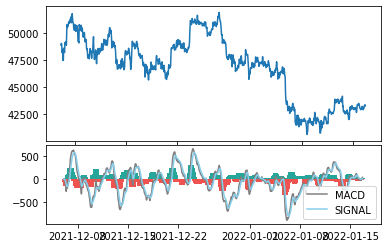

In [13]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(df['close'], df['macd'], df['signal'], df['hist'])


In [14]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(df['close'], df)

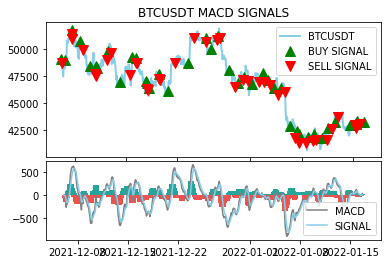

In [15]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['close'], color = 'skyblue', linewidth = 2, label = str(coin))
ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title(str(coin+" MACD SIGNALS"))
ax2.plot(df['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(df['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(df)):
    if str(df['hist'][i])[0] == '-':
        ax2.bar(df.index[i], df['hist'][i], color = '#ef5350')
    else:
        ax2.bar(df.index[i], df['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()


In [ ]:
macd_signal

In [16]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = df['macd']
signal = df['signal']
close_price = df['close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(df.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,macd,signal,macd_signal,macd_position
dateTime,,,,,
2021-12-06 02:00:00,48873.08,0.000000,0.000000,0,1
2021-12-06 03:00:00,49013.72,11.219145,2.243829,1,1
2021-12-06 04:00:00,48999.78,18.769198,5.548903,0,1
2021-12-06 05:00:00,48688.55,-0.356878,4.367747,-1,0
2021-12-06 06:00:00,48167.18,-56.928397,-7.891482,0,0
...,...,...,...,...,...
2022-01-16 13:00:00,43145.83,-12.667532,-2.398589,0,0
2022-01-16 14:00:00,43297.33,5.857145,-0.747442,1,1
2022-01-16 15:00:00,43221.98,14.293207,2.260688,0,1


# RSI - Relative Strength Index

In [17]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df['rsi_14'] = get_rsi(df['close'], 14)
df = df.dropna()


In [18]:
df

,open,high,low,close,volume,macd,signal,hist,rsi_14
dateTime,,,,,,,,,
2021-12-06 06:00:00,48672.09,48747.40,48064.26,48167.18,13.007586,-56.928397,-7.891482,-49.036915,65.717345
2021-12-06 07:00:00,48140.90,48426.21,47751.82,48426.21,9.360184,-79.938693,-22.300924,-57.637769,69.288679
2021-12-06 08:00:00,48416.67,49410.09,47842.48,48249.86,47.714943,-111.123527,-40.065445,-71.058083,64.372092
2021-12-06 09:00:00,48111.68,48320.27,47146.36,47439.18,29.496123,-198.959355,-71.844227,-127.115128,47.637674
2021-12-06 10:00:00,47415.75,47794.07,47294.34,47495.63,11.810367,-261.006121,-109.676606,-151.329515,48.638932
...,...,...,...,...,...,...,...,...,...
2022-01-16 13:00:00,43003.75,43186.39,42606.27,43145.83,9.801632,-12.667532,-2.398589,-10.268944,52.226521
2022-01-16 14:00:00,43167.40,43416.07,43046.40,43297.33,7.155894,5.857145,-0.747442,6.604587,57.309333
2022-01-16 15:00:00,43315.11,43350.64,43155.81,43221.98,6.256289,14.293207,2.260688,12.032519,54.219548


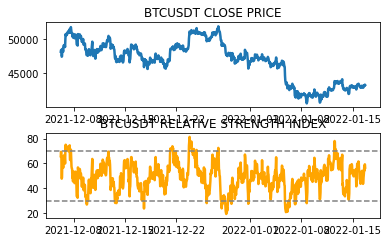

In [19]:
ax3 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax4 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax3.plot(df['close'], linewidth = 2.5)
ax3.set_title(str(coin+" CLOSE PRICE"))
ax4.plot(df['rsi_14'], color = 'orange', linewidth = 2.5)
ax4.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax4.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax4.set_title(str(coin+" RELATIVE STRENGTH INDEX"))
plt.show()

In [20]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

rsi_buy_price, rsi_sell_price, rsi_signal = implement_rsi_strategy(df['close'], df['rsi_14'])

In [21]:
df

,open,high,low,close,volume,macd,signal,hist,rsi_14
dateTime,,,,,,,,,
2021-12-06 06:00:00,48672.09,48747.40,48064.26,48167.18,13.007586,-56.928397,-7.891482,-49.036915,65.717345
2021-12-06 07:00:00,48140.90,48426.21,47751.82,48426.21,9.360184,-79.938693,-22.300924,-57.637769,69.288679
2021-12-06 08:00:00,48416.67,49410.09,47842.48,48249.86,47.714943,-111.123527,-40.065445,-71.058083,64.372092
2021-12-06 09:00:00,48111.68,48320.27,47146.36,47439.18,29.496123,-198.959355,-71.844227,-127.115128,47.637674
2021-12-06 10:00:00,47415.75,47794.07,47294.34,47495.63,11.810367,-261.006121,-109.676606,-151.329515,48.638932
...,...,...,...,...,...,...,...,...,...
2022-01-16 13:00:00,43003.75,43186.39,42606.27,43145.83,9.801632,-12.667532,-2.398589,-10.268944,52.226521
2022-01-16 14:00:00,43167.40,43416.07,43046.40,43297.33,7.155894,5.857145,-0.747442,6.604587,57.309333
2022-01-16 15:00:00,43315.11,43350.64,43155.81,43221.98,6.256289,14.293207,2.260688,12.032519,54.219548


In [ ]:
print(len(df.index))

996


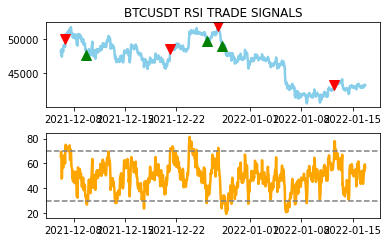

In [22]:
ax5 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax6 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax5.plot(df['close'], linewidth = 2.5, color = 'skyblue', label = 'RSI')
ax5.plot(df.index, rsi_buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax5.plot(df.index, rsi_sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax5.set_title(str(coin+" RSI TRADE SIGNALS"))
ax6.plot(df['rsi_14'], color = 'orange', linewidth = 2.5)
ax6.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax6.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [23]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = df['rsi_14']
close_price = df['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(df.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,close,rsi_14,rsi_signal,rsi_position
dateTime,,,,
2021-12-06 06:00:00,48167.18,65.717345,0,1
2021-12-06 07:00:00,48426.21,69.288679,0,1
2021-12-06 08:00:00,48249.86,64.372092,0,1
2021-12-06 09:00:00,47439.18,47.637674,0,1
2021-12-06 10:00:00,47495.63,48.638932,0,1


# STOCHASTIC OSCILLATOR

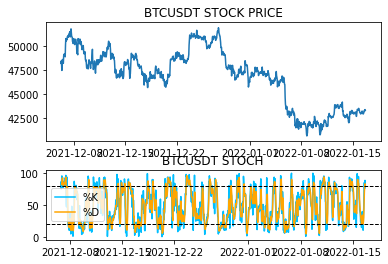

In [24]:

stoch_data = df.copy()

stoch_data['high'] = stoch_data['high'].rolling(14).max()
stoch_data['low'] = stoch_data['low'].rolling(14).min()
stoch_data['%k'] = (stoch_data["close"] - stoch_data['low'])*100/(stoch_data['high'] - stoch_data['low'])
stoch_data['%d'] = stoch_data['%k'].rolling(3).mean()

def plot_stoch(price, k, d):
    ax7 = plt.subplot2grid((9, 1), (0,0), rowspan = 5, colspan = 1)
    ax8 = plt.subplot2grid((9, 1), (6,0), rowspan = 3, colspan = 1)
    ax7.plot(price)
    ax7.set_title(f'{coin} STOCK PRICE')
    ax8.plot(k, color = 'deepskyblue', linewidth = 1.5, label = '%K')
    ax8.plot(d, color = 'orange', linewidth = 1.5, label = '%D')
    ax8.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
    ax8.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
    ax8.set_title(f'{coin} STOCH')
    ax8.legend()
    plt.show()
    
plot_stoch(df['close'], stoch_data['%k'], stoch_data['%d'])

In [25]:
def implement_stoch_strategy(prices, k, d):    
    buy_price = []
    sell_price = []
    stoch_signal = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 20 and d[i] < 20 and k[i] < d[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        elif k[i] > 80 and d[i] > 80 and k[i] > d[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_signal.append(0)
            
    return buy_price, sell_price, stoch_signal
            
stoch_buy_price, stoch_sell_price, stoch_signal = implement_stoch_strategy(stoch_data['close'], stoch_data['%k'], stoch_data['%d'])

In [26]:
position = []
for i in range(len(stoch_signal)):
    if stoch_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(stoch_data['close'])):
    if stoch_signal[i] == 1:
        position[i] = 1
    elif stoch_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
k = stoch_data['%k']
d = stoch_data['%d']
close_price = stoch_data['close']
stoch_signal = pd.DataFrame(stoch_signal).rename(columns = {0:'stoch_signal'}).set_index(stoch_data.index)
position = pd.DataFrame(position).rename(columns = {0:'stoch_position'}).set_index(stoch_data.index)

frames = [close_price, k, d, stoch_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.tail()

,close,%k,%d,stoch_signal,stoch_position
dateTime,,,,,
2022-01-16 13:00:00,43145.83,77.172607,52.767301,0,0
2022-01-16 14:00:00,43297.33,85.337120,69.281158,0,0
2022-01-16 15:00:00,43221.98,76.032354,79.514027,0,0
2022-01-16 16:00:00,43380.28,88.732088,83.367187,0,0
2022-01-16 17:00:00,43316.53,81.423822,82.062754,0,0
